In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import os
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


## **1. Cargar Rutas y Definición de Parámetros**

In [2]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/"
ZIP_PATH_GDRIVE = os.path.join(PROJECT_PATH, 'cards-image-datasetclassification.zip')

# Rutas locales para descomprimir
LOCAL_ZIP_PATH = '/content/datos.zip'
LOCAL_DATA_DIR = '/content/datos_imagenes/'

shutil.copyfile(ZIP_PATH_GDRIVE, LOCAL_ZIP_PATH)
shutil.unpack_archive(LOCAL_ZIP_PATH, LOCAL_DATA_DIR)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(LOCAL_DATA_DIR, 'train')
valid_dir = os.path.join(LOCAL_DATA_DIR, 'valid')
test_dir = os.path.join(LOCAL_DATA_DIR, 'test')

class_names = sorted(os.listdir(train_dir))
NUM_CLASSES = len(class_names)
print(f"Encontradas {NUM_CLASSES} clases.")

Encontradas 53 clases.


## **2. Crear Generadores de Datos (3 conjuntos)**

In [3]:
# Data Augmentation sólo para TRAIN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de TRAIN
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Generador de VALIDATION
validation_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Generador de TEST
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## **3. Modelo v1 (CNN Simple)**

In [ ]:
model_v1 = Sequential([
    # Capa Convolucional 1
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    # Capa Convolucional 2
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    # Capa Convolucional 3
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # Clasificador
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),  # Regularización para evitar overfitting
    Dense(NUM_CLASSES, activation="softmax") # Multiclase
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_v1.compile(optimizer="adam",
              loss="categorical_crossentropy", # Multiclase
              metrics=["accuracy"])

print(">> Entrenando Modelo v1 (CNN)")
history_v1 = model_v1.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

>> Entrenando Modelo v1 (CNN)
Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 100s 402ms/step - accuracy: 0.0639 - loss: 3.8699 - val_accuracy: 0.3434 - val_loss: 2.3111
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 91s 380ms/step - accuracy: 0.2335 - loss: 2.8686 - val_accuracy: 0.4981 - val_loss: 1.8030
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 90s 378ms/step - accuracy: 0.2893 - loss: 2.5353 - val_accuracy: 0.4830 - val_loss: 1.6404
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 90s 378ms/step - accuracy: 0.3596 - loss: 2.3035 - val_accuracy: 0.6113 - val_loss: 1.3573
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 91s 380ms/step - accuracy: 0.4003 - loss: 2.1703 - val_accuracy: 0.6302 - val_loss: 1.2559
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 91s 379ms/step - accuracy: 0.4328 - loss: 2.0394 - val_accuracy: 0.6830 - val_loss: 1.1377
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 89s 372ms/step - accuracy: 0.4657 - loss: 1.9171 - val_accuracy: 0.7208 - val_loss: 0.9785
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 90s 375ms/st

<Figure size 640x480 with 0 Axes>

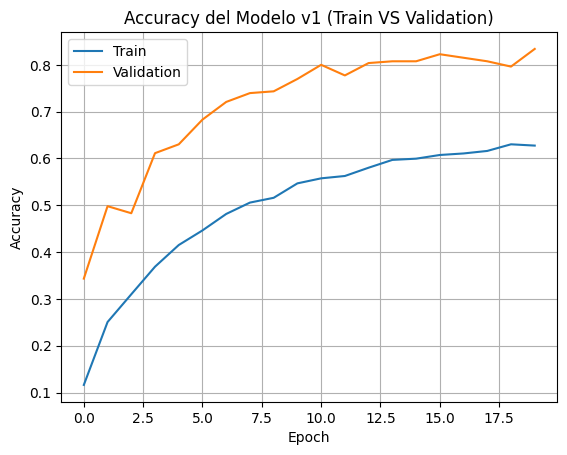

In [ ]:
hist_v1_df = pd.DataFrame(history_v1.history)
plt.figure()
hist_v1_df[['accuracy', 'val_accuracy']].plot()

plt.title("Accuracy del Modelo v1 (Train VS Validation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)

<Figure size 640x480 with 0 Axes>

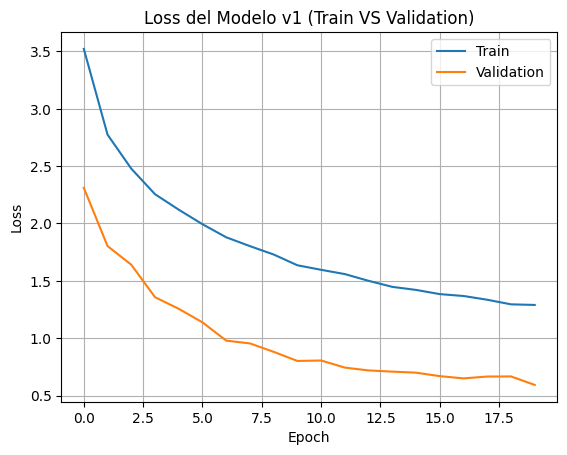

In [ ]:
plt.figure()
hist_v1_df[['loss', 'val_loss']].plot()

plt.title("Loss del Modelo v1 (Train VS Validation)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)

## **4. Evaluación**

>> Evaluación del Modelo v1 con TEST


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.56      1.00      0.71         5
  ace of diamonds       0.83      1.00      0.91         5
    ace of hearts       0.56      1.00      0.71         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.71      1.00      0.83         5
eight of diamonds       0.71      1.00      0.83         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       0.67      0.80      0.73         5
    five of clubs       0.75      0.60      0.67         5
 five of diamonds       0.80      0.80      0.80         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       0.67      0.80      0.73         5
    four of clubs       0.60      0.60      0.60         5
 four of diamonds       0.83      1.00      0.91         5
   four of hearts       0.83      1.00      0.91         5
   four of spades

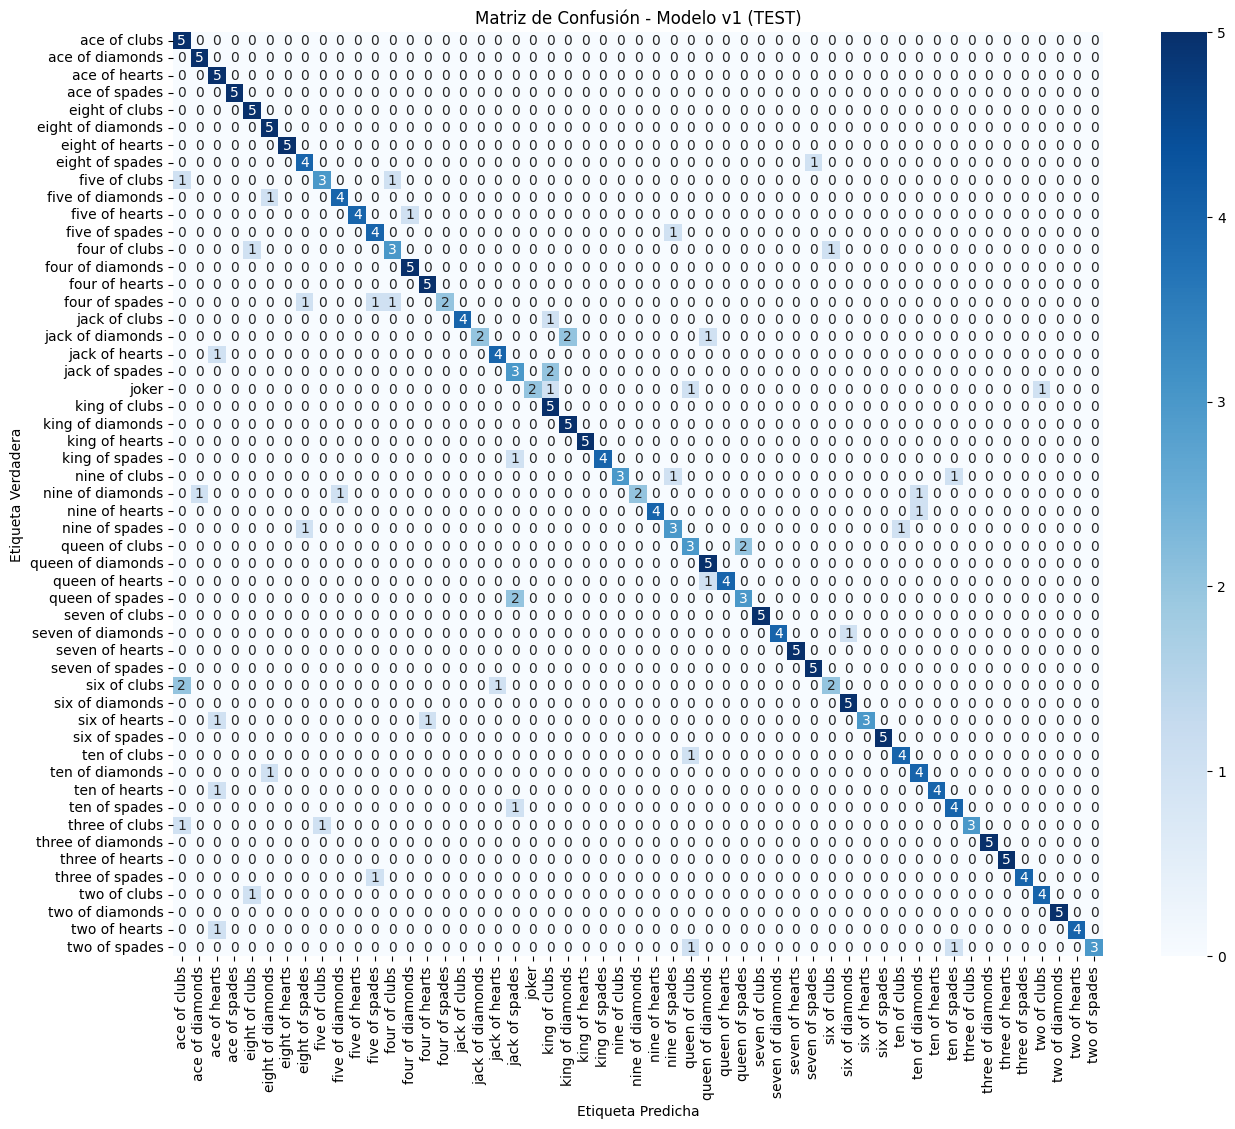

In [ ]:
print(">> Evaluación del Modelo v1 con TEST")

# Obtener predicciones
y_pred_prob = model_v1.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Reporte de Clasificación
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_df, annot=True, fmt="g", cmap="Blues")
plt.title("Matriz de Confusión - Modelo v1 (TEST)")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.show()

In [ ]:
model_v1.save(PROJECT_PATH + "classifier_model_v1.h5")
print(f"Modelo guardado exitosamente en {PROJECT_PATH}")

Modelo guardado exitosamente en /content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/


## **5. Modelo v2 (Mejora: Transfer Learning)**

In [4]:
# Cargar MobileNetV2 pre-entrenado (sin incluir la capa de clasificación)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False

model_v2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
print(">> Entrenando Modelo v2 (Transfer Learning con MobileNetV2)")
history_v2 = model_v2.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

>> Entrenando Modelo v2 (Transfer Learning con MobileNetV2)
Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 506ms/step - accuracy: 0.1427 - loss: 3.2465 - val_accuracy: 0.3358 - val_loss: 2.1556
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 390ms/step - accuracy: 0.2782 - loss: 2.4829 - val_accuracy: 0.4151 - val_loss: 1.9069
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 96s 402ms/step - accuracy: 0.3501 - loss: 2.1512 - val_accuracy: 0.4604 - val_loss: 1.7753
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 391ms/step - accuracy: 0.4021 - loss: 1.9817 - val_accuracy: 0.4679 - val_loss: 1.6595
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 94s 391ms/step - accuracy: 0.4105 - loss: 1.9012 - val_accuracy: 0.4642 - val_loss: 1.5966
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 389ms/step - accuracy: 0.4394 - loss: 1.8172 - val_accuracy: 0.4792 - val_loss: 1.5959
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 94s 393ms/step - accuracy: 0.4515 - loss: 1.7560 - val_accuracy: 0.4906 - val_loss: 1.5691
Epoch 8/15
239/239 ━━━

<Figure size 640x480 with 0 Axes>

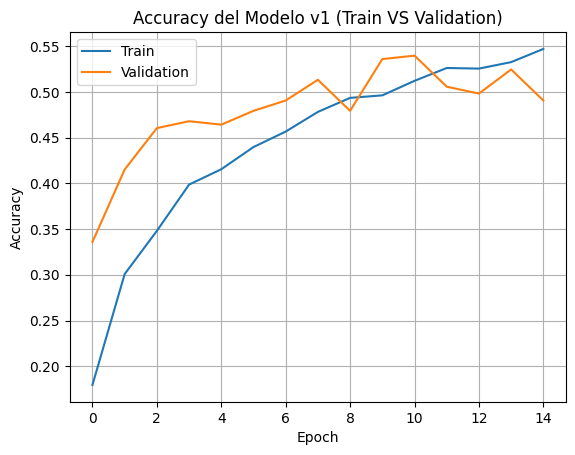

In [9]:
# Visualizar el progreso del entrenamiento
hist_v2_df = pd.DataFrame(history_v2.history)

plt.figure()
hist_v2_df[['accuracy', 'val_accuracy']].plot()

plt.title("Accuracy del Modelo v1 (Train VS Validation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)

<Figure size 640x480 with 0 Axes>

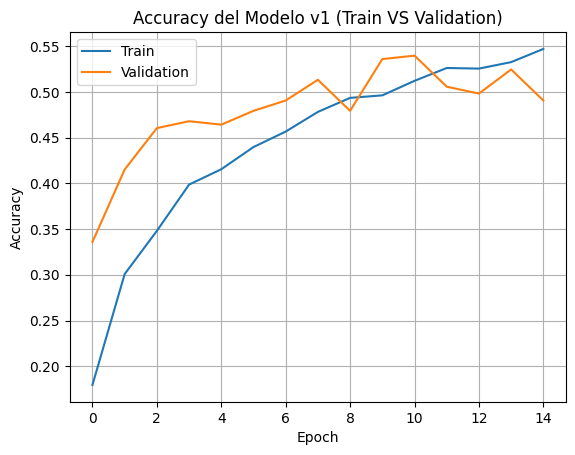

In [10]:
plt.figure()
hist_v2_df[['accuracy', 'val_accuracy']].plot()

plt.title("Accuracy del Modelo v1 (Train VS Validation)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)

In [12]:
model_v2.save(PROJECT_PATH + "classifier_model_v2.h5")
print(f">> Modelo guardado exitosamente en {PROJECT_PATH}")

with open(PROJECT_PATH + 'history_v2.json', 'w') as f:
    json.dump(history_v2.history, f)
    print(f">> Historial guardado exitosamente en {PROJECT_PATH}")

>> Modelo guardado exitosamente en /content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/
>> Historial guardado exitosamente en /content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/



>> Evaluación del Modelo v2 con TEST


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.56      1.00      0.71         5
  ace of diamonds       0.83      1.00      0.91         5
    ace of hearts       0.50      1.00      0.67         5
    ace of spades       0.62      1.00      0.77         5
   eight of clubs       0.50      0.40      0.44         5
eight of diamonds       0.33      0.80      0.47         5
  eight of hearts       0.80      0.80      0.80         5
  eight of spades       0.50      0.40      0.44         5
    five of clubs       0.60      0.60      0.60         5
 five of diamonds       0.62      1.00      0.77         5
   five of hearts       1.00      0.60      0.75         5
   five of spades       0.50      0.80      0.62         5
    four of clubs       1.00      0.20      0.33         5
 four of diamonds       0.83      1.00      0.91         5
   four of hearts       0.60      0.60      0.60         5
   four of spade

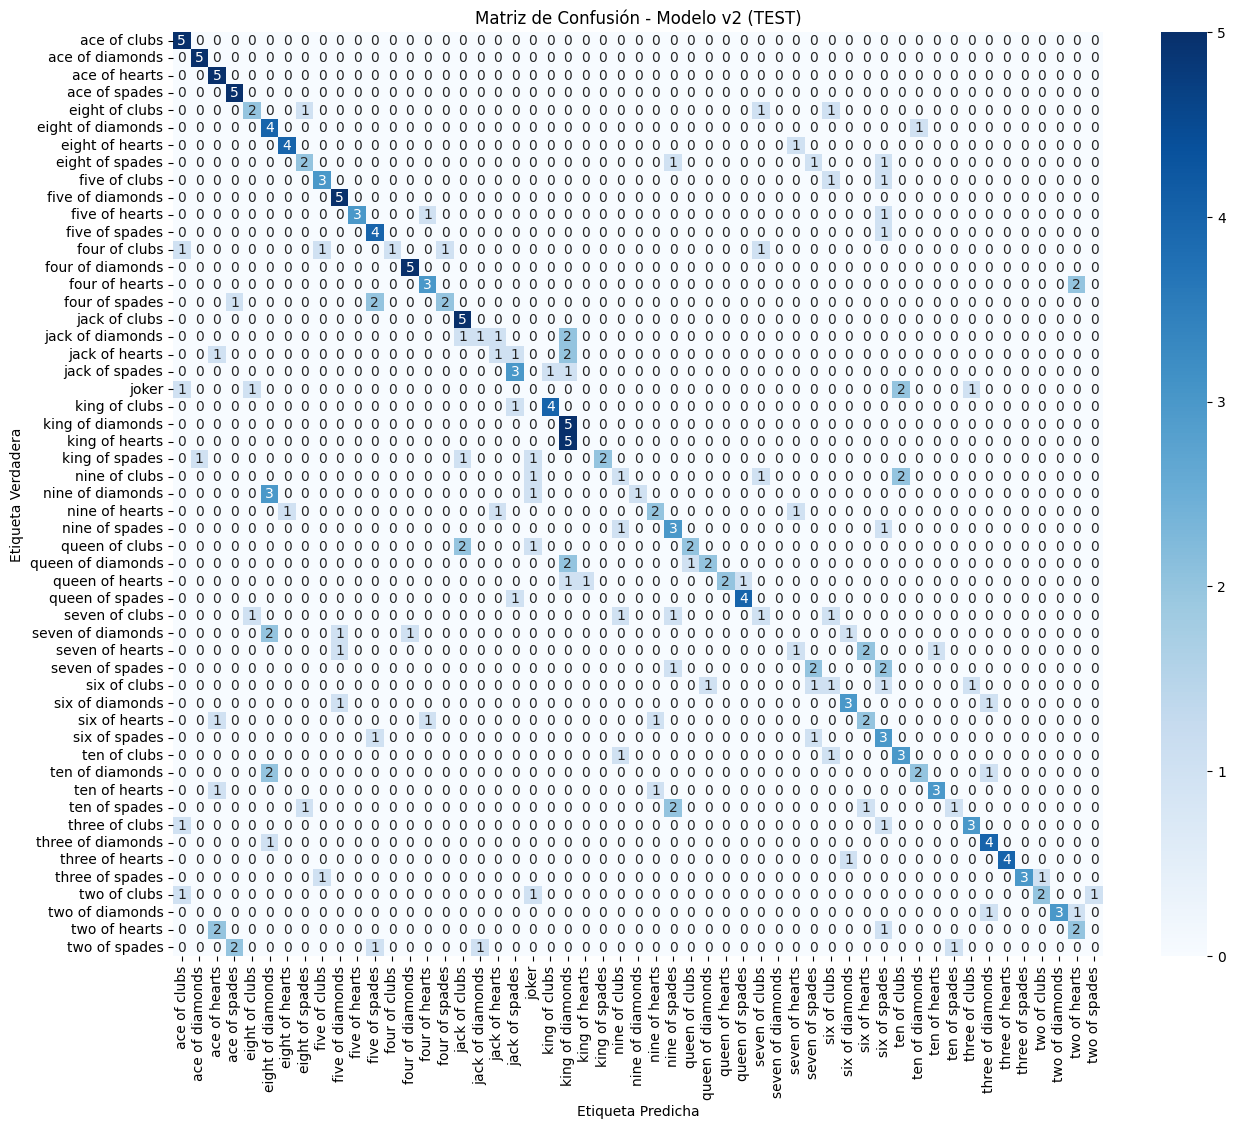

In [13]:
# Evaluación del modelo v2
print("\n>> Evaluación del Modelo v2 con TEST")

# Obtener predicciones
y_pred_prob_v2 = model_v2.predict(test_generator)
y_pred_v2 = np.argmax(y_pred_prob_v2, axis=1)
y_true = test_generator.classes

# Reporte de Clasificación
print(classification_report(y_true, y_pred_v2, target_names=class_names, zero_division=0))

# Matriz de Confusión
cm_v2 = confusion_matrix(y_true, y_pred_v2)
cm_v2_df = pd.DataFrame(cm_v2, index=class_names, columns=class_names)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_v2_df, annot=True, fmt="g", cmap="Blues")
plt.title("Matriz de Confusión - Modelo v2 (TEST)")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.show()

## **6. Comparación de métricas**

## **7. Guardar modelo mejorado**